# Secrets behind recipes

Team members: Tianyang Dong, Wei Jiang, Huajian Qiu, Jiahua Wu

---
## 0 Import libraries and recipe dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In [128]:
recipe = pd.read_csv('data/RAW_recipes.csv')

In [129]:
recipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
name              231636 non-null object
id                231637 non-null int64
minutes           231637 non-null int64
contributor_id    231637 non-null int64
submitted         231637 non-null object
tags              231637 non-null object
nutrition         231637 non-null object
n_steps           231637 non-null int64
steps             231637 non-null object
description       226658 non-null object
ingredients       231637 non-null object
n_ingredients     231637 non-null int64
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [130]:
# Split the nutrition list
nutritions_list = ["calories(kJ)", "total_fat(g)", "sugar(g)", "sodium(mg)", "protein(g)", "sat_fat(g)", "carbs(g)"]
recipe['nutrition'] = recipe['nutrition'].apply(eval)
recipe[nutritions_list] = pd.DataFrame(recipe.nutrition.values.tolist(), index=recipe.index)
recipe = recipe.drop(['nutrition'], axis=1)

---

# 1 Data cleaning of recipes

## 1.1 Map recipe to countries (regions) and continents

First, drop the rows that have nan values on column 'name'. Since 'description' is irrelavent to our analysis, we will not deal with the missing values in column 'description'.

The information about country/region is extracted from the tags, for example, there are tags like 'american', 'southern-united-states', 'scottish'. These tags will be mapped to countries if they describes a part of a country, e.g. 'southern-united-states' to 'America', otherwise they will be mapped to a region, e.g. 'caribbean' to 'Caribbean'. Later the countries will be mapped to continents. 

Due to the variety of country indicators in the tags (for example 'hunan', 'szchuan' indicate China), nlp libraries like spacy cannot ideally identify and capture the country info, so we choose to parse it manually. The resulting mapping is explicitly defined in utils.py for readability of the notebook.

In the end, we get 96940 rows of recipes with country labeled.

In [131]:
from utils import extract_country

In [132]:
recipe.drop(index = recipe[recipe['name'].isna()].index, inplace = True)

In [133]:
recipe.tags = recipe.tags.apply(eval)

In [134]:
recipe_tag = recipe.explode('tags')

In [135]:
recipe_country = extract_country(recipe_tag);

In [136]:
len(recipe_country.country.unique())

66

Recipes of 66 countries are identified.

In [137]:
recipe_count = recipe_country.groupby('country').count()[['name']].rename(columns={'name': 'recipes count'}).sort_values(by='recipes count')

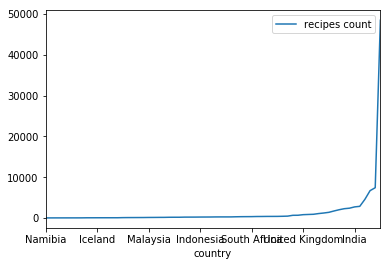

In [138]:
recipe_count.plot()

As we can see, the data is skewed and some countries have too few samples. To reduce the noise in following analysis, we decide to drop the countries with less than 100 recipes in our dataframe.

In [139]:
underrepresented_country_list = recipe_count[recipe_count['recipes count'] < 50].index.tolist()

In [140]:
len(underrepresented_country_list)

15

In [141]:
recipe_country = recipe_country[~recipe_country.country.isin(underrepresented_country_list)]

In [146]:
len(recipe_country)

96294

15 countries are removed. Thus there remains 51 countries in the dataset. And there are 96294 recipes left, which is suffcient for our study.

## 1.2 Ingredients Cleaning

We notice that in some texts of ingredients there are superfluous descriptive words. For example, for flour there are "buckwheat flour", "all-purpose flour" while they should all be categorized as flour. We identify these adjectives as words that are tagged as "JJ"(adjective) by the nltk library. However, we spot some error in tagging (e.g. bean, cake are tagged as adjective) so we first remove some already known ingredients from the adjective set by opearting set difference with the available ingredient list and then we manually check the remaining words to rectify errors.

Then we employ the lemmatization functionality of spacy library to unify the form of words and we furthermore remove the stopping words and punctuations.

Showcase:

In [142]:
recipe_country[recipe_country.id == 27846].ingredients.tolist()

["['margarine', 'all-purpose flour', 'sugar', 'baking powder', 'salt', 'lemon, rind of', 'ground mace', 'egg', 'water', 'purple plums', 'flour', 'ground cinnamon', 'slivered almonds']"]

In [143]:
recipe_country[recipe_country.id == 344542].ingredients.tolist()

["['potatoes', 'zucchini', 'yellow onions', 'garlic cloves', 'self-raising flour', 'eggs', 'of fresh mint', 'fresh basil', 'cracked black pepper', 'sea salt', 'olive oil', 'greek yogurt']",
 "['potatoes', 'zucchini', 'yellow onions', 'garlic cloves', 'self-raising flour', 'eggs', 'of fresh mint', 'fresh basil', 'cracked black pepper', 'sea salt', 'olive oil', 'greek yogurt']"]

In the first example above, we spot some superfluous adjectives like "all-purpose" in "all-purpose flour" and abnormal expression like "lemon, rind of" which should be "lemon rind" and this can be achieved by removing the comma and 'of'. In the second example, "of fresh mint" should be corrected by removing "fresh" and "of". 

In [145]:
len(recipe_country.explode('ingredients').ingredients.unique())

79095

Before cleaning, there are 79095 different ingredients in terms of text. For the comparison of the order of magnitude, recall that in our dataset there are nearly 96000 recipes, such giant number of ingredients implies that many ingredients of the same type are disguised by redundant words such as adjectives and brands' names.

We start by removing adjectives. We initially used spacy library since it is a more recent nlp library but it turned out to be too slow so we turned to nltk.

In [18]:
import nltk

In [19]:
# Collection of words tagged as adjective by nltk
s = set()
for ind, ls in enumerate(recipe_country.ingredients.apply(eval)):
    for word in ls:
        tokens = nltk.word_tokenize(word)
        tagged = nltk.pos_tag(tokens)
        s = s.union(set([ele[0] for ele in tagged if ele[1] == 'JJ']))

In [20]:
# List of misclassified words obtained by manual check
wrongly_classified_list = ['acorn', 'adzuki', 'aji', 'amaranth', 'ancho', 'andouille', 'annatto', 'argan', 'astragalus', 'angelica',
               'bean', 'balsamic', 'bison', 'bisquick', 'blackfish', 'bulgur', 'cachous', 'cake', 'canary', 'cantal', 'cauliflow', 
               'chicory', 'chipotle', 'chocolate', 'chive', 'citric', 'claret', 'cornbread', 'couscous', 'crayfish', 
               'crust', 'curd', 'custard', 'dasheen', 'dough', 'espresso', 'fava', 'fajita', 'feta', 'fish', 'flax', 'garbanzo',
               'geese', 'gelatin', 'gingerbread', 'goldfish', 'gravy', 'lactose', 'lasagna', 'lecithin', 'lemonade', 
               'loin', 'lumpfish', 'macaroni', 'marshmallow', 'mastic', 'menudo', 'mesquite', 'mochiko', 'nacho', 'nixtamal'
               ,'noodle', 'nopal', 'nougat', 'nut', 'parmesan', 'pebble', 'pecan', 'peppercorn', 'phyllo', 'pinto', 'pita',
               'pomfret', 'popcorn', 'poppy', 'cornbread-muffin', 'five-spice', 'garlic-chipotle', 'geese', 'gingerbread', 'gruyere', 
               'guacamole', 'gumbo', 'jalapeno', 'oatmeal', 'pecan', 'peppercorn', 'potatoes', 'quorn', 'robin', 'salad', 'sambal',
               'sandwich', 'sauce', 'savory', 'shellfish', 'shortcrust', 'shortbread', 'soup', 'sourdough', 'soy', 'soybean', 'sushi', 
               'taco', 'udon', 'umeboshi', 'vermicelli', 'waffle', 'weisswurst']

In [21]:
seasoning = ['salt', 'sugar','cheese', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vineger','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg']

In [22]:
# The categoreis (dairy, grain, vegetable, fruit, meat, seafood) are collected from supercook (https://www.supercook.com/#/recipes). 
# 220 various ingredients are identified. 
dairy = ['egg', 'milk', 'cream', 'yogurt', 'frosting'] 
grain = ['rice', 'pasta', 'flour', 'bread', 'tortilla', 'pancake', 'pie', 'pizza']
vegetable = ['tomato', 'potato', 'carrot',
              'broccoli', 'corn', 'spinach', 'mushroom', 'beans', 'salad green', 'cucumber',
              'pickle', 'avocado', 'zucchini', 'cilantro', 'frozen vegetable', 'asparagus',
             'cabbage', 'cauliflower', 'kale', 'mixed vegetable', 'pumpkin', 'squash', 'scallion',
             'shallot', 'eggplant', 'beet', 'horseradish', 'leek', 'caper', 'brussels sprout',
             'artichoke', 'chia', 'radish', 'sauerkraut', 'artichoke', 'arugula', 'capsicum',
             'bok choy', 'parsnip', 'okra', 'yam', 'fennel', 'turnip', 'pea', 'seaweed', 'chard', 'collard',
             'pimiento', 'watercress', 'tomatillo', 'rocket' 'bamboo shoot', 'rutabaga', 'endive',
              'jicama',  'kohlrabi', 'palm', 'butternut', 'daikon', 'radicchio', 'porcini', 'jerusalem artichoke'
             'cress', 'chestnut', 'dulse', 'micro green', 'burdock', 'chayote']
fruit = ['lemon', 'apple', 'banana', 'lime', 'strawberry', 'orange', 'pineapple', 'blueberry', 
             'raisin', 'coconut', 'grape', 'peach', 'cranberry', 'mango', 'pear', 'blackberry', 'cherry',
        'watermelon', 'kiwi', 'grapefruit', 'mandarin', 'craisins', 'cantaloupe', 'plum', 'apricot',
         'clementine', 'prune', 'apple butter', 'pomegranate', 'nectarine', 'fig', 'tangerine', 'papaya',
         'rhubarb', 'sultana', 'plantain', 'currant', 'passion fruit', 'guava', 'persimmon', 'lychee',
         'lingonberry', 'tangelo', 'kumquat', 'boysenberry', 'star fruit', 'quince', 'honeydew', 'crabapple']
meat = ['chicken', 'beef', 'bacon', 'sausage', 'steak', 'ham', 'hot dog', 'pork', 'turkey', 'pepperoni',
       'salami', 'spam', 'venison','bologna', 'bratwurst', 'prosciutto', 'lamb', 'pancetta', 'duck', 'veal',
        'cornish hen', 'deer',  'pastrami', 'rabbit', 'elk', 'marrow bone', 'goose', 'quail', 'oxtail',
 'pheasant', 'moose', 'foie gra', 'boar', 'snail', 'pigeon', 'grouse', 'ostrich', 'soppressata', 'alligator']
seafood =  ['tuna', 'salmon', 'tilapia', 'fish fillets', 'cod', 'anchovy', 'sardine', 'whitefish',
            'halibut', 'trout', 'haddock', 'flounder', 'catfish', 'mahi mahi', 'mackerel', 'sole', 'sea bass',
            'red snapper', 'swordfish', 'pollock', 'herring', 'perch', 'grouper', 'caviar', 'monkfish', 
            'rockfish', 'pike', 'barramundi', 'eel', 'bluefish', 'carp', 'cuttlefish', 'pompano', 'arctic char',
            'john dory', 'marlin', 'amberjack', 'sturgeon', 'shrimp', 'crab', 'prawn', 'scallop', 'clam',
            'lobster', 'mussel', 'oyster', 'squid', 'calamari', 'crawfish', 'octopus', 'cockle', 'conch',
            'sea urchin']
unions = dairy + vegetable + fruit + meat + seafood + grain

In [23]:
adj_to_be_removed = list(s.difference(set(unions + seasoning + wrongly_classified_list)))

In [89]:
# Add some more adjective observed in the ingredient list after the initial attempts of removal.
adj_to_be_removed += ['ground', 'baby', 'bloody', 'jack', 'j', 'john', 'grey', 'gold', 'medium', 'mexico', 
                      'mrs dash', 'mrs', 'non', 'nonpareil', 'z', 'pepsi', 'sodium', 'simply', 'silver', 'sec',
                      'pure', 'pink', 'southwest', 'style', 'tony', 'uncle brand', 'uncle', 'uncle bens', 'use']

In [90]:
# Remove adjectives from the column of ingredients defined above
# nltk fails to identify adjective in form of present, passed participle and possessive case ('s) 
# thus we add those cases here.
def remove_adj(ls):
    for ind, string in enumerate(ls):
        ls[ind] = ' '.join(list(filter(lambda x: x not in adj_to_be_removed 
                                       and not x.endswith('ing') 
                                       and not x.endswith('ed')
                                       and not x.endswith("'s"), string.split())))
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [26]:
recipe_country.ingredients = recipe_country.ingredients.apply(eval).apply(remove_adj)

In later operation we find that some ingredients are connected using 'and' and '&' so we split them here.

In [64]:
def split_parallel(ls):
    for string in ls:
        for prop in [' and ', '&']:
            if prop in string:
                ls += string.split(prop)
                ls.remove(string)
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [65]:
recipe_country.ingredients = recipe_country.ingredients.apply(split_parallel)

Apply lemmatization to the ingredients to simplify word formats. At the same time, stopping words, punctuation and number are removed.

In [34]:
import spacy
nlp = spacy.load('en')

In [75]:
def word_cleaning(ls):
    for ind, string in enumerate(ls):
        doc = nlp(string)
        ls[ind] = ' '.join([token.lemma_ for token in doc 
                            if token.lemma_ != '-PRON-'
                            and not token.is_stop
                            and token.text.isalpha()])
    ls = list(set(ls))
    if '' in ls:
        ls.remove('')
    return ls

In [76]:
recipe_country.ingredients = recipe_country.ingredients.apply(word_cleaning)

After lemmatization, some adjectives appear so we perform adjective removal again.

In [91]:
recipe_country.ingredients = recipe_country.ingredients.apply(remove_adj)

In [96]:
recipe_country = recipe_country.dropna(subset=['ingredients']).reset_index(drop=True)

In [113]:
len(recipe_country.explode('ingredients').ingredients.unique())

5764

After cleaning, it remains 5764 different ingredients.

In [97]:
recipe_country.to_pickle('recipe_country.pkl')

Link: https://drive.google.com/file/d/1ZBRfYZTGGHZEG4gvP5BRz1IqJl4bUyAL/view?usp=sharing

In [3]:
recipe_country = pd.read_pickle('data/recipe_country.pkl')

## 1.3 Extract seasoning for each recipe

In the column 'ingredients', all the ingredients needed in the recipe are listed. To learn in detail about each country's eating habits, we investigate a particular type of ingredient: seasoning. This study can be justified by the fact that although seasoning is added in small quantities, it plays an important and sometimes a decisive role in the taste of dishes. Therefore its usage can well reflect the eating preference of different regions.

In [98]:
recipe_country_ingre = recipe_country.copy()

In [99]:
seasonings = ['salt', 'sugar', 'butter', 'spice','pepper','chili', 'onion','garlic', 'oil',
         'ginger','vinegar','clove', 'herb','mayonnaise','vanilla','honey', 'cinnamon', 'curry',
        'mustard', 'olive', 'basil', 'oregano', 'sesame', 'thyme','paprika', 'cajun', 'cardamom',
        'sage', 'rosemary','nutmeg', 'parsley', 'coriander', 'bay', 'cumin', 'tarragon','allspice',
        'cayenne', 'anise', 'celery', 'dill', 'wasabi', 'mace', 'syrup', 'cilantro',
        'salt', 'spice', 'pepper', 'chili', 'onion', 'clove', 'herb', 'olive', 'nutmeg', 'sauce']

In [100]:
# We identify seasonings as ingredients containing words in the seasoning list instead of exactly the words in the
# list to preserve diversity of seasonings in different countries.
def identify_seasoning(ls):
    res = [string for string in ls if sum(ingredient in string for ingredient in seasonings) > 0]
    if len(res) > 0:
        return res
    return None

In [101]:
recipe_country_ingre['seasoning'] = recipe_country_ingre['ingredients'].apply(identify_seasoning)
recipe_country_ingre.dropna(subset=['seasoning'], inplace=True)
recipe_country_seasoning = recipe_country_ingre.explode('seasoning')

Top 30 frequently used seasoning for each country is computed.

In [102]:
season_country = recipe_country_seasoning.groupby(['country', 'seasoning'])['id'].count().groupby('country').nlargest(30)

In [103]:
season_country = season_country.to_frame().droplevel(0).reset_index()  

In [104]:
# Show frequency of seasonings at the top-30 seasoning list of each country
season_country.groupby('seasoning').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'}).tail(25)

,country count
seasoning,
basil leave,1
wasabi,1
wasabi paste,1
wasabi powder,1
balsamic vinegar,1
kalamata olive,1
grain mustard,1
ginger paste,1
spaghetti sauce,1


In [105]:
season_country.country[season_country['seasoning'] == 'wasabi']

807    Japan
Name: country, dtype: object

In [106]:
season_country.country[season_country['seasoning'] == 'tarragon']

471    France
Name: country, dtype: object

In [107]:
season_country.country[season_country['seasoning'] == 'star anise']

858     Malaysia
1524     Vietnam
Name: country, dtype: object

In [108]:
season_country.country[season_country['seasoning'] == 'rice wine vinegar']

265           China
796           Japan
1288    South Korea
Name: country, dtype: object

In [109]:
season_country.country[season_country['seasoning'] == 'soy sauce']

45        Australia
178          Canada
201       Caribbean
240           China
544          Hawaii
637       Indonesia
780           Japan
847        Malaysia
974     New Zealand
1052    Philippines
1114      Polynesia
1260    South Korea
1386       Thailand
1509        Vietnam
Name: country, dtype: object

Recall that we identify 51 coutries in total. Therefore, as universal flavorings, salt, salt, pepper, onion, oil, sugar and butter almost appear in recipes of all countries studied. In contrast, at the bottom of the sorted list, we may recognize some regional specialties. Used as a pungent condiment for sushi, wasabi is indispensible in most of the japanese recipes. Tarragon is one of the four "fines herbes" of French cooking, and is particularly suitable for chicken, fish, and egg dishes. Soy sauce and rice wine vinegar is mostly used in Asia.

#### Here we show the China's top 20 most frequently used seasonings  as an example. Word cloud is a popular tool for showing word frequencies and visualizing results.

In [110]:
from utils import plt_wordcloud

In [111]:
data = season_country[season_country['country'] == 'China']['seasoning'].values

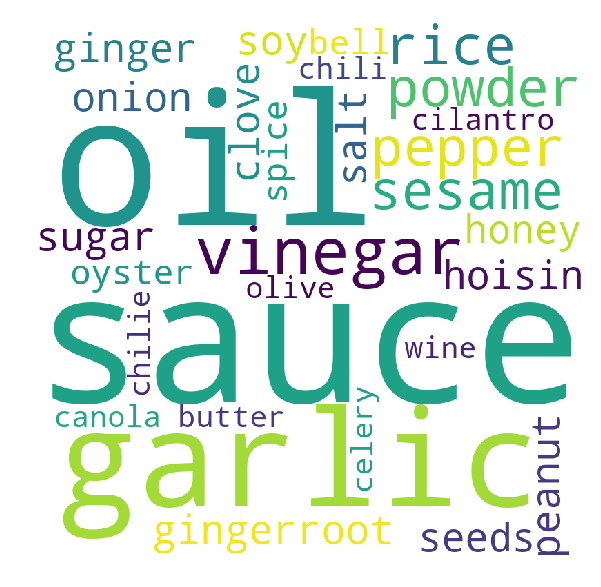

In [112]:
plt_wordcloud(data)

## 1.4 Extract cooking methods for each recipe

Beside the ingredients, cooking method also varies across country. When 'boiling eggs' or 'frying eggs', the ingredients used are the same, yet the look, the smell and the flavor of the dishes are distinct. In this section we extract cooking methods from column 'steps' from the dataframe.

In [97]:
method_list = ['bake', 'barbecue', 'blanch', 'boil', 'braise', 'brine', 'broil', 'caramelize', 
               'crock pot','deglaze','devein','dice','distill','drain','emulsify',
               'fry','grate','griddle','grill','knead','leaven','marinate','mash','microwave',
               'parboil','pickle','poach','pressure cook','puree','roast','saute','scald',
               'scramble','shred','simmer','slow cook','smoke','sous-vide','steam',
               'stew','tenderize','thicken','toast','whip','whisk']

In [98]:
recipe_cooking = recipe_country.copy()

In [99]:
recipe_cooking['steps'] = recipe_cooking['steps'].apply(eval)

In [155]:
# We apply lemmatization to unify form of words.
recipe_cooking['steps'] = recipe_cooking['steps'].apply(word_cleaning).apply(eval_trim)

In [156]:
recipe_cooking.dropna(subset=['steps'], inplace=True)

In [157]:
# We identify words in the method list that also appear in the text of "steps" and gather them as the cooking 
# methods used in the preperation of the recipe. 
def identify_cooking(row):
    r_list = set([])
    for stc in row:
        s_list = re.findall(r"[\w']+", stc)
        for word in s_list:
            if word in method_list:
                r_list.add(word)
    return list(r_list)

In [158]:
recipe_cooking['method'] = recipe_cooking['steps'].apply(identify_cooking)

In [159]:
recipe_cooking.reset_index(drop = True, inplace = True)

In [160]:
recipe_cooking.drop(index = recipe_cooking[recipe_cooking['method'].apply(len) == 0].index, inplace = True)   

In [161]:
recipe_cooking_e = recipe_cooking.explode('method')

In [169]:
# Take out the top 10 used cooking methods in recipes of each country
method_country = recipe_cooking_e.groupby(['country', 'method'])['id'].count().groupby('country').nlargest(10)
method_country = method_country.to_frame().droplevel(0).reset_index()  

In [170]:
# Show frequency of each cooking method in the top-10 method list
method_country.groupby('method').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

,country count
method,
bake,51
boil,51
simmer,51
drain,51
fry,50
saute,46
whisk,40
thicken,32
grill,27


In [171]:
method_country.country[method_country['method'] == 'dice']

346    Palestine
Name: country, dtype: object

In [172]:
method_country.country[method_country['method'] == 'broil']

428    South Korea
Name: country, dtype: object

In [177]:
recipe_cooking.to_pickle('recipe_cooking.pkl')

Link: https://drive.google.com/file/d/1auyrjRxY9DUflrQlULKI3B1k3OZ_D0e_/view?usp=sharing

Basic methods like boil, simmer, drain and bake are largely present in recipes of various countries for food cooking. Broil is popular in korean recipes mainly because of "Korean BBQ".

#### Japan's cooking method wordcloud

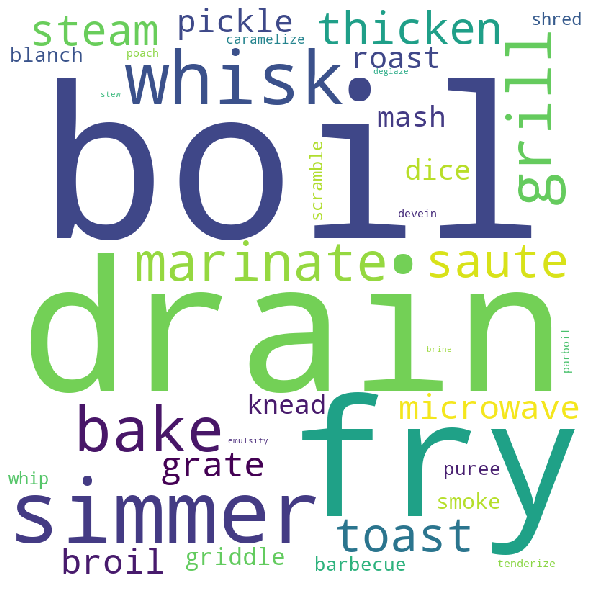

In [167]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'Japan']['method'].values
plt_wordcloud(data)

#### Italy's cooking method wordcloud

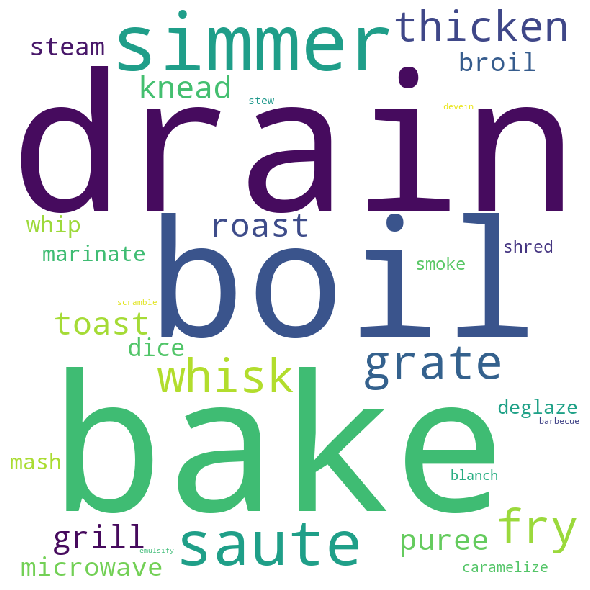

In [168]:
data = recipe_cooking_e[recipe_cooking_e['country'] == 'Italy']['method'].values
plt_wordcloud(data)

Italian recipes and japanese recipes reflect respectively typical western and asian food cooking habits. Both of them are mostly prepared by draining, boiling and simmering, which is the case of most of the countries. However, They still slightly differ from each other: marinate is more present as a food preprocessing step in japanese recipes while baking appears more frequently in italian recipes. Such difference is reasonable since food made by baking (for instance bread and cake) is essential in western diet while marinate plays an important role in east-asian cuisine for refining the taste of ingredients.

## 1.5 Ingredients Analysis

In [114]:
recipe_country_ingreds = recipe_country.explode('ingredients')

In [115]:
recipe_country_ingreds = recipe_country_ingreds[~recipe_country_ingreds.ingredients.isin(seasoning)]

In [116]:
# Collect the top 10 frequently used ingredients (seasoning removed) in each country
ingredient_country = recipe_country_ingreds.groupby(['country', 'ingredients'])['id'].count().groupby('country').nlargest(10)
ingredient_country = ingredient_country.to_frame().droplevel(0).reset_index()

In [117]:
# Show frequency of each ingredients in the top-10 list
ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'}).head(10)

,country count
ingredients,
water,51
garlic clove,42
flour,32
lemon juice,30
eggs,30
milk,27
olive oil,26
tomato,24
cream,20


At the top we can see some universal ingredients such as water, garlic clove and eggs.

In [118]:
# Show frequency of each cooking method in the top-5 method list
ingre_country_count = ingredient_country.groupby('ingredients').count().sort_values(by='id', ascending=False).drop('id', axis=1).rename(columns={'country': 'country count'})

In [119]:
# We take out "specialties" which are ingredients that only appear in the top-5 list of a particular country
specialties = ingre_country_count[ingre_country_count['country count'] == 1]

In [120]:
# Add country name to the dataframe
country_df = pd.DataFrame({'country':[ingredient_country.country[ingredient_country.ingredients == ingred].tolist()[0] 
            for ingred in specialties.index], 'ingredients': specialties.index.tolist()})

In [121]:
specialties = specialties.reset_index().merge(country_df)

In [122]:
recipe_ingre_count = recipe_country_ingreds.groupby('ingredients').count().reset_index()

In [123]:
# Add ratio of appearance in dishes of the country
specialties['frequency ratio'] = pd.Series([len(recipe_country_ingreds[(recipe_country_ingreds.country == country) 
                                                                       & (recipe_country_ingreds.ingredients == ingredients)])\
                                            / len(recipe_country[(recipe_country.country == country)]) 
                                             for country, ingredients in zip(specialties.country, specialties.ingredients)])

In [124]:
specialties.sort_values('country', ascending=False)

,ingredients,country count,country,frequency ratio
12,bean sprout,1,Vietnam,0.156695
2,caster sugar,1,United Kingdom,0.091136
18,lemongrass,1,Thailand,0.168874
29,curry paste,1,Thailand,0.198675
27,peanut,1,Thailand,0.168874
19,gruyere cheese,1,Switzerland,0.114667
4,breadcrumbs,1,Sweden,0.093834
3,cardamom pod,1,Saudi Arabia,0.127451
24,mushroom,1,Russia,0.120735
17,kielbasa,1,Poland,0.110565


At the bottom we see many country specialties and just to name a few: parmesan cheese and mozzarella cheese for Italy, feta cheese for Greece, mirin and sake for Japan and gruyere cheese for Switzerland. 

These particular ingredients appear in more than 10% of the countries' recipes. Specifically, parmesan cheese is used in more than a third of italian recipes and feta cheese is also very popular in greek recipes.

#### Japan's popular ingredients for cooking

In [125]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Japan']['ingredients'].values

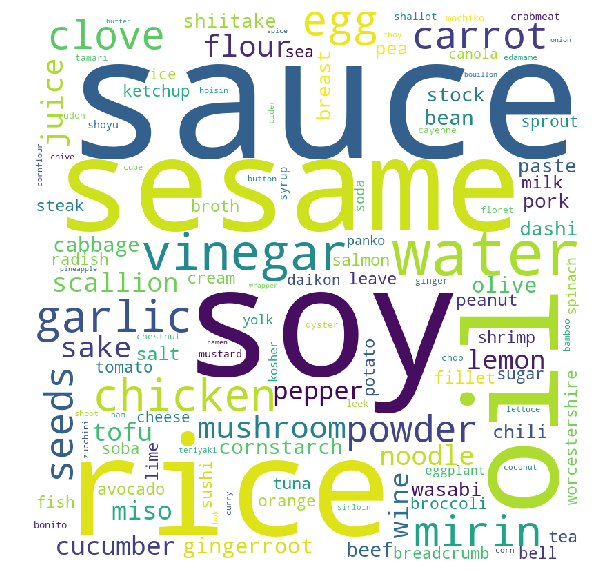

In [126]:
plt_wordcloud(data)

#### Italy's popular ingredients for cooking

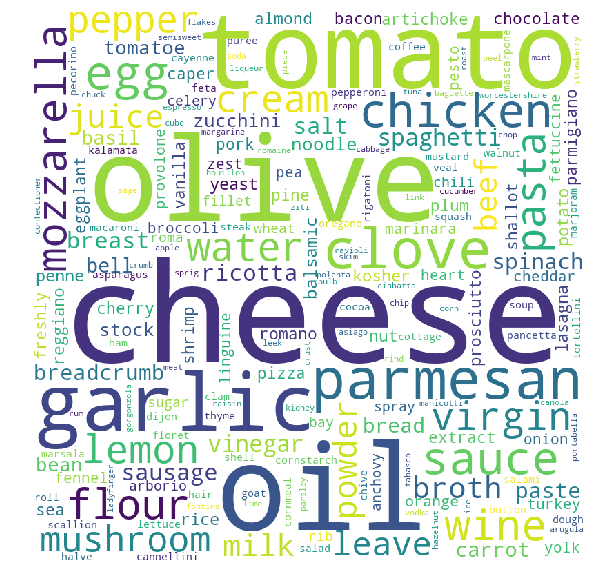

In [127]:
data = recipe_country_ingreds[recipe_country_ingreds['country'] == 'Italy']['ingredients'].values
plt_wordcloud(data)

The wordclouds shown above seem to be in line with common sense. 

In the japanese recipes, we can notice some typical east-asian ingredients such as rice, sauce, sesame and tofu and at the same time some japanese specialties emerge: mirin(an essential condiment used in Japanese cuisine. It is a type of rice wine similar to sake, but with a lower alcohol content and higher sugar content.) and sake(a japanese traditional rice wine).

Similarly, in italian recipes, different kinds of cheese(parmesan cheese and mozzarella cheese), olive, spaghetti and pasta are largely present. They particularly love parmesan cheese as it appears in 35% of the italien recipes. 

Cloudword images on some more countries can be found in our data story.

## 1.6 Drawing the choropleth map of the nutrition facts

Nutrition in the diet has a direct impact on people's health. We draw here a choropleth map based on the average nutrition facts of the dishes from different countries.

In [133]:
avg_nutrition = recipe_country.groupby("country").mean()

In [134]:
avg_nutrition = avg_nutrition[nutritions_list].reset_index()

In [135]:
avg_nutrition.head()

,country,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,Argentina,533.674194,51.887097,34.104839,26.814516,43.782258,45.637097,10.887097
1,Australia,473.954699,36.583949,82.931714,20.187962,34.920803,47.578317,15.264696
2,Austria,607.671765,46.129412,121.288235,21.541176,34.335294,59.923529,22.076471
3,Belgium,523.245455,44.915152,52.412121,20.327273,44.109091,58.812121,13.054545
4,Brazil,437.537247,35.076923,71.072874,19.870445,34.850202,39.761134,12.097166


In [139]:
import geopandas
from matplotlib import cm

In [140]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [141]:
avg_nutrition = avg_nutrition[~avg_nutrition.country.isin(['Caribbean', 'Hawaii', 'Melanesia', 'Polynesia'])].reset_index(drop=True)

In [142]:
merged = world.set_index('name').join(avg_nutrition.set_index('country'))

In [143]:
def plot_nutrition(column):
    # plot as usual, grab the axes 'ax' returned by the plot
    colormap = "OrRd"   # add _r to reverse the colormap
    ax = merged.plot(color="grey", figsize=(12, 9))
    ax2 = merged.dropna().plot(ax=ax, column=column, cmap=colormap, figsize=[12,9])

    # map marginal/face deco
    ax2.set_title("Average " + column + " in recipes from different countries" + \
                  "\n (missing values are plotted in grey)")

    # colorbar will be created by ...
    fig = ax2.get_figure()
    # add colorbar axes to the figure
    # here, need trial-and-error to get [l,b,w,h] right
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
    cbax.set_title(column)

    sm = plt.cm.ScalarMappable(cmap=colormap, \
                    norm=plt.Normalize(vmin=min(merged[column].dropna()), vmax=max(merged[column].dropna())))
    # at this stage, 
    # 'cbax' is just a blank axes, with un needed labels on x and y axes

    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    fig.colorbar(sm, cax=cbax, format="%d")

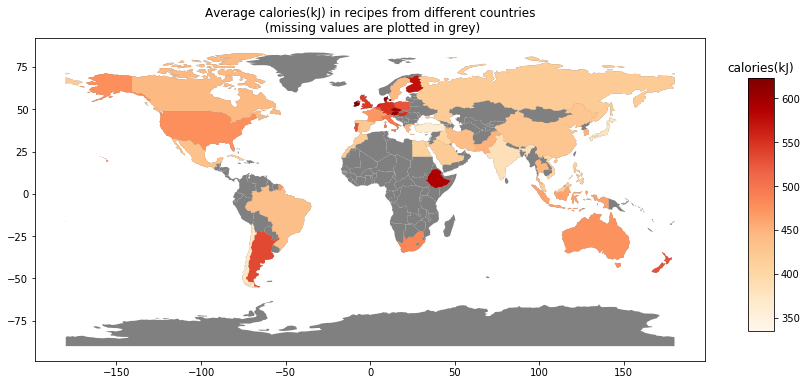

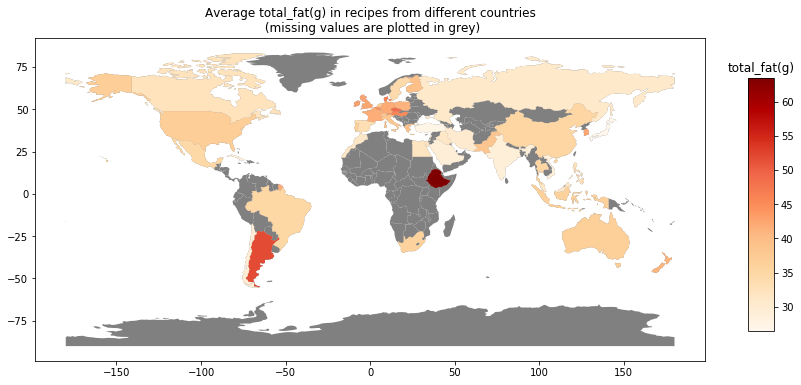

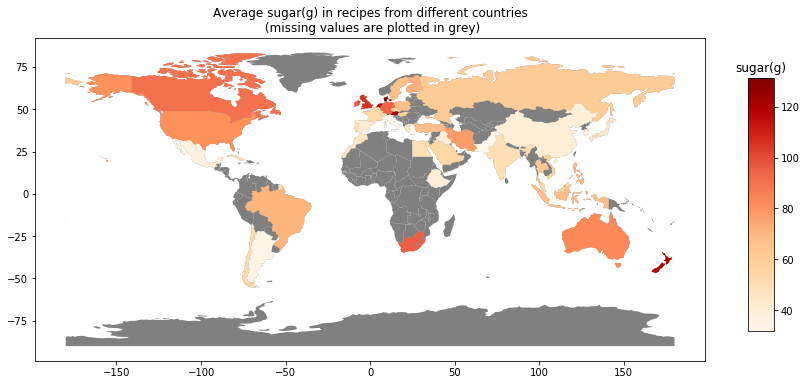

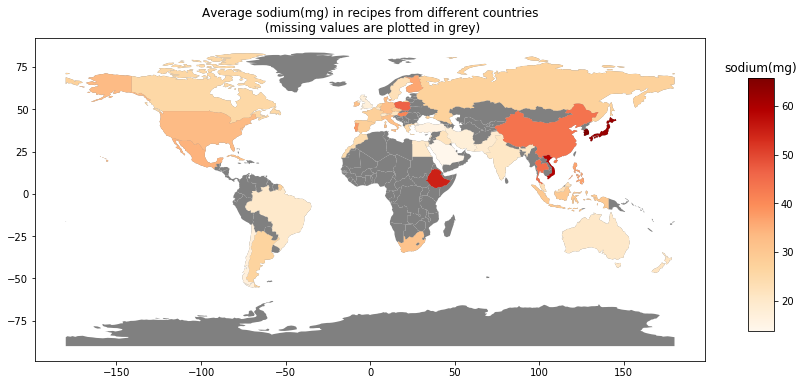

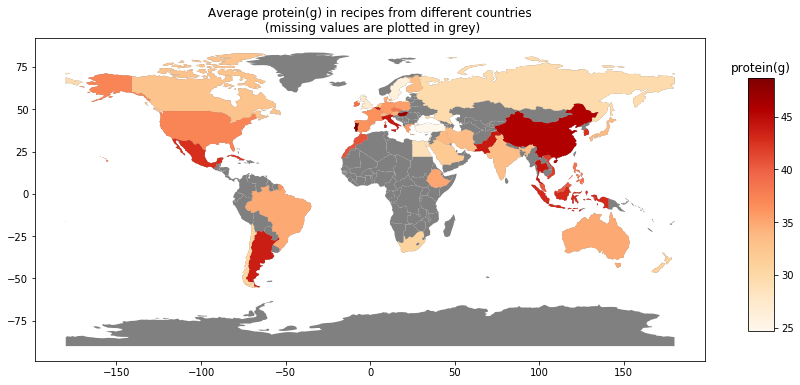

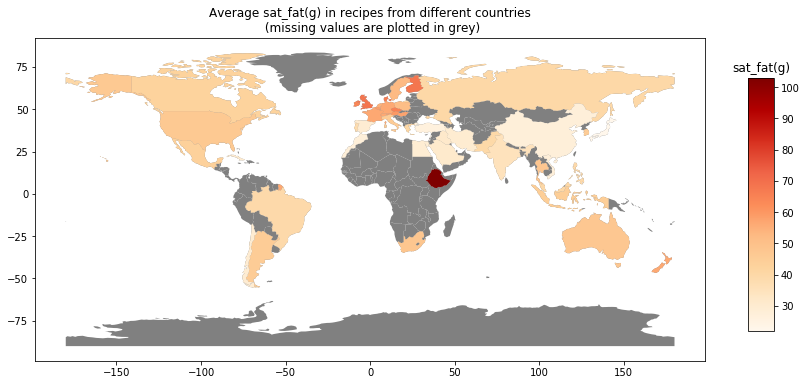

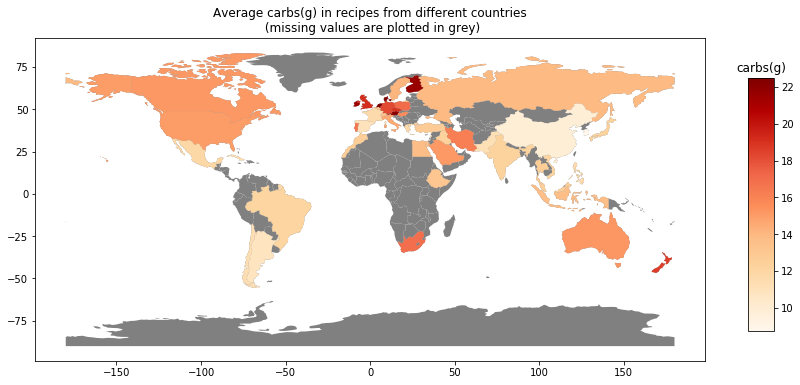

In [145]:
for column in nutritions_list:
    plot_nutrition(column)

Clearly, recipes originated from western countries(european countries, US, Canada and Australia) tend to contain relatively high calories, high fat, high sugar, high carbs and low sodium. On the contrary, recipes of east asian countries tend to contain high sodium and high proteins. These characterizaions have important influence on statistics related to health that we include later.

# 2. Incoporating WHO dataset

To study the potential relationship between eating habits and public health, we include some statistics related to public health from WHO in our dataset. They are available on WHO website.

The data imported comprise:
- life span
- the ratio of population dead from some health issues(overweight, high blood pressure, high blood glucose, etc.) and certain non-communicable diseases believed to have close relationship to diet(dabetes mellitus and cardiovascular diseases) of various countries.
- the total number of people dead from NCD(non-communicable diseases)

To render the total NCD disease death data consistent on scale, we further add each nation's population to calculate the total NCD death rate.

Since the most recent available data on diseases are collected in 2016, for the sake of coherence, we use 2016 version of all the statistics. The first one to read in is the life span.

In [75]:
health_data= pd.read_csv('data/RAW_lifespan.csv')
health_data = health_data[health_data['Indicator']=='Life expectancy at birth (years)']
health_data = health_data[health_data['Dim1'] == 'Both sexes']
health_data.drop(columns=['Indicator','Period','Dim1'],inplace=True)
health_data.rename(columns={'First Tooltip':'Life span'},inplace=True)
health_data.reset_index(drop=True, inplace=True)

Then we add some food-related common health indices which include 'overweight', 'blood_pressure', 'blood_glucose', 'cholesterol'. The data shows the ratio of population in a country suffering from these common diseases and the death rate of various NCD(non-communicable diseases, including Malignant neoplasms, Diabetes mellitus, Cardiovascular diseases, Chronic obstructive pulmonary disease) in different countries.

In [76]:
dataset_list = ['data_overweight.csv', 'data_blood_glucose.csv', 'data_blood_pressure.csv', 
                'data_cholesterol.csv', 'data_NCD_death.csv']
column_names = ['Overweight(%)', 'High Blood Glucose(%)', 'High Blood Pressure(%)', 'High Cholesterol(%)',
                'NCD death probability(%)']

In [77]:
for ind, dataset in enumerate(dataset_list):
    data_sub = pd.read_csv(os.path.join('data', dataset))
    data_sub.rename(columns={'First Tooltip':column_names[ind]}, inplace=True)
    health_data = health_data.merge(data_sub[['Location',column_names[ind]]])

In [78]:
cols = ['Overweight(%)','High Blood Glucose(%)','High Blood Pressure(%)','High Cholesterol(%)']
for c in cols:
    health_data[c]=health_data[c].str.split('[',expand=True)[0].astype('float')

In [82]:
diseases = ['Malignant neoplasms','Diabetes mellitus','Cardiovascular diseases','Chronic obstructive pulmonary disease']
for d in diseases:
    data_sub=data_disease.loc[data_disease['Dim2']==d].copy()
    data_sub.rename(columns={'disease(%)':d+' death(%)'},inplace=True)
    health_data=pd.merge(health_data,data_sub[['Location',d+' death(%)']],on='Location')

We further add the total number of deaths due to NCD in a country. To calculate the total NCD death rate, we also import the population of different countries.

In [79]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]

In [80]:
data_pop= pd.read_csv('data/data_population.csv')
data_pop = data_pop[data_pop['Time']==2016][['Location','PopTotal']]
health_data = pd.merge(health_data, data_pop)
health_data.rename(columns={'PopTotal': 'PopTotal(k)'}, inplace=True)

In [81]:
data_disease= pd.read_csv('data/data_disease_death.csv')
data_disease = data_disease[['Location','Dim2','First Tooltip']]
data_disease= pd.merge(data_disease,data_pop,on='Location')
data_disease['disease(%)']=data_disease['First Tooltip']/data_disease['PopTotal']/10

The GNI per capita is the dollar value of a country's final income in a year, divided by its population. It should be reflecting the average before tax income of a country's citizens. In particular, a country's GNI per capita tends to be closely linked with other indicators of public health of a country. For example the life span in wealthy countries is usually higher than poorer ones. The data comes from world bank: https://data.worldbank.org/indicator/NY.GNP.PCAP.CD and according to the criterion given by world bank (see the table below), the countries are divided into different income groups (High-income, Upper-middle-income, Lower-middle-income, Low-income). Again we use data in 2016.

| Thresholds    |  GNI/Capita (current US$)|
| ------------- |:-------------:|
| Low-income    | < 1006 |
| Lower-middle income     | 1,006 - 3,955     |
| Upper-middle income | 3,956 - 12,235      |
|High-income    | > 12,235|

In [83]:
data_gni=pd.read_csv('data/GNI_per_capita.csv')
data_gni=data_gni[['Country Name','2016']]
data_gni.rename(columns={'Country Name':'Location','2016':'GNP per capita($)'},inplace=True)

In [84]:
health_data = pd.merge(health_data,data_gni,on='Location')

In [85]:
health_data.dropna(inplace=True)
health_data.reset_index(drop=True, inplace=True)

In [128]:
health_data['income group'] = np.nan

In [129]:
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] < 1006].index] = 'low'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 1006)
                                              & (health_data['GNP per capita($)'] < 3955)].index] = 'lower-middle'
health_data['income group'].iloc[health_data[(health_data['GNP per capita($)'] >= 3956)
                                              & (health_data['GNP per capita($)'] < 12235)].index] = 'upper-middle'
health_data['income group'].iloc[health_data[health_data['GNP per capita($)'] > 12235].index] = 'high'

In [130]:
health_data.rename(columns={'Location': 'country'},inplace=True)

# 3. Relationship between eating habits and health

Recipes reflect the eating habits of a country. In the following, based on the data collected from recipes, we study the relation between nutrition in food and health indices as well as relation between ingredients + cooking methods with health indices to identify good eating and cooking practices that are beneficial to one's health.

## 3.1 Nutrition in food v.s. health indices

In essence, the significance of eating is to provide nutrition to our body so that it can go on functioning. Therefore, the nutrition in food should have a direct impact on health.

In [131]:
nutrition_health = pd.merge(health_data, avg_nutrition, on='country')
nutrition_health.head()

,country,Life span,Overweight(%),High Blood Glucose(%),High Blood Pressure(%),High Cholesterol(%),NCD death probability(%),PopTotal(k),Malignant neoplasms death(%),Diabetes mellitus death(%),...,Chronic obstructive pulmonary disease death(%),GNP per capita($),income group,calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
0,Angola,62.63,27.5,8.2,29.7,30.9,16.5,28842.482,0.029314,0.008248,...,0.012489,3770.0,lower-middle,362.830769,28.076923,58.461538,18.769231,32.692308,32.307692,10.846154
1,Argentina,76.95,62.7,9.7,22.6,50.5,15.8,43508.459,0.150906,0.021221,...,0.079123,12220.0,upper-middle,533.674194,51.887097,34.104839,26.814516,43.782258,45.637097,10.887097
2,Australia,82.90,64.5,5.9,15.2,55.2,9.1,24262.710,0.188557,0.019594,...,0.048379,54190.0,high,473.585870,36.557821,82.864675,20.169420,34.888928,47.525483,15.252724
3,Austria,81.87,54.3,4.3,21.0,59.7,11.4,8747.306,0.238919,0.038892,...,0.046963,46130.0,high,607.671765,46.129412,121.288235,21.541176,34.335294,59.923529,22.076471
4,Belgium,81.16,59.5,4.6,17.5,62.4,11.4,11354.407,0.253708,0.014822,...,0.076164,42530.0,high,523.245455,44.915152,52.412121,20.327273,44.109091,58.812121,13.054545


In [133]:
nutrition_health.groupby('income group').count()['country']

income group
high            23
low              2
lower-middle    10
upper-middle    13
Name: country, dtype: int64

In [121]:
corr = nutrition_health.corr()
corr

,Life span,Overweight(%),High Blood Glucose(%),High Blood Pressure(%),High Cholesterol(%),NCD death probability(%),PopTotal(k),Malignant neoplasms death(%),Diabetes mellitus death(%),Cardiovascular diseases death(%),Chronic obstructive pulmonary disease death(%),GNP per capita($),calories(kJ),total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,1.000000,0.591809,-0.385441,-0.818796,0.850515,-0.818057,-0.154184,0.781950,-0.074608,0.264136,0.554877,0.758390,-0.019346,-0.201545,0.105705,-0.034275,-0.274183,0.023903,0.231150
Overweight(%),0.591809,1.000000,0.213889,-0.470747,0.528459,-0.409011,-0.426471,0.361868,0.146544,0.180265,0.084977,0.376128,-0.110066,-0.256731,0.006464,-0.401622,-0.283514,-0.178871,0.169016
High Blood Glucose(%),-0.385441,0.213889,1.000000,0.298977,-0.438992,0.481823,0.035347,-0.582748,0.125788,-0.107768,-0.508581,-0.602868,-0.549179,-0.443209,-0.385285,-0.268511,-0.061136,-0.620778,-0.403770
High Blood Pressure(%),-0.818796,-0.470747,0.298977,1.000000,-0.635239,0.719545,0.019705,-0.458621,0.044468,0.026962,-0.422896,-0.668382,0.182386,0.321737,-0.207238,0.184875,0.400406,0.098870,-0.143934
High Cholesterol(%),0.850515,0.528459,-0.438992,-0.635239,1.000000,-0.658726,-0.298753,0.794864,0.062000,0.281450,0.531847,0.780290,0.128170,-0.129554,0.208579,0.073553,-0.138658,0.179748,0.371017
NCD death probability(%),-0.818057,-0.409011,0.481823,0.719545,-0.658726,1.000000,0.212025,-0.557548,0.156168,0.082165,-0.379916,-0.742875,-0.093326,-0.003314,-0.144050,0.149312,0.373968,-0.144323,-0.234070
PopTotal(k),-0.154184,-0.426471,0.035347,0.019705,-0.298753,0.212025,1.000000,-0.143008,-0.028350,-0.012487,0.222973,-0.220627,-0.173991,-0.099900,-0.166203,0.082833,0.087426,-0.173515,-0.231077
Malignant neoplasms death(%),0.781950,0.361868,-0.582748,-0.458621,0.794864,-0.557548,-0.143008,1.000000,-0.039599,0.571538,0.756594,0.670274,0.264921,0.069742,0.173582,0.237852,-0.049537,0.248687,0.353023
Diabetes mellitus death(%),-0.074608,0.146544,0.125788,0.044468,0.062000,0.156168,-0.028350,-0.039599,1.000000,0.110967,0.082634,-0.176107,0.010154,-0.045355,0.062231,-0.054953,0.031003,-0.013914,0.080036
Cardiovascular diseases death(%),0.264136,0.180265,-0.107768,0.026962,0.281450,0.082165,-0.012487,0.571538,0.110967,1.000000,0.436873,0.113601,0.026866,0.006224,-0.135933,0.106124,-0.004866,0.075720,0.024643


In [136]:
nutri_heal_upper = nutrition_health[nutrition_health['income group']=='upper-middle'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_upper.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.094489,-0.758104,-0.123344,-0.241802,-0.331398,-0.893454
Overweight(%),-0.236477,-0.296466,-0.739028,-0.676605,-0.417754,-0.259595
High Blood Glucose(%),-0.467102,-0.207516,-0.437397,-0.505322,-0.491112,-0.175369
High Blood Pressure(%),0.238220,0.719123,0.019791,0.314213,0.434412,0.850625
High Cholesterol(%),0.278847,-0.406516,0.138065,0.150344,0.440987,-0.362940
NCD death probability(%),0.048282,0.607396,0.059817,0.073591,0.196046,0.670311
Malignant neoplasms death(%),0.333663,-0.269826,0.303307,-0.016924,0.010188,-0.541603
Diabetes mellitus death(%),0.146073,0.310600,0.292201,0.100671,0.530405,0.389659
Cardiovascular diseases death(%),0.093381,-0.277337,0.268699,0.021818,-0.314051,-0.457089
Chronic obstructive pulmonary disease death(%),0.743509,-0.081122,0.457906,0.355492,0.344972,-0.191764


In [137]:
nutri_heal_high = nutrition_health[nutrition_health['income group']=='high'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_high.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,-0.118066,0.041935,0.092570,-0.176838,0.006591,-0.114971
Overweight(%),0.160958,0.088013,-0.706930,0.020629,0.170352,0.031947
High Blood Glucose(%),-0.421698,-0.294500,-0.182110,-0.078474,-0.535559,-0.240336
High Blood Pressure(%),0.255541,-0.223397,0.329120,0.444333,0.058526,0.059407
High Cholesterol(%),0.333851,0.197351,0.358863,0.173707,0.477643,0.223845
NCD death probability(%),0.296728,-0.040211,0.131726,0.355207,0.077295,0.094461
Malignant neoplasms death(%),0.431069,0.009762,0.604046,0.455030,0.249463,0.087378
Diabetes mellitus death(%),0.334444,0.120909,-0.021459,0.484130,0.030134,0.188547
Cardiovascular diseases death(%),0.444475,-0.149638,0.423107,0.455232,0.239119,0.074970
Chronic obstructive pulmonary disease death(%),0.202065,-0.082886,0.390727,0.384098,-0.106461,-0.122575


In [138]:
nutri_heal_lower = nutrition_health[nutrition_health['income group']=='lower-middle'].drop(columns = ['GNP per capita($)','income group','PopTotal(k)'])
corr = nutri_heal_lower.corr()
corr.iloc[:10,11:]

,total_fat(g),sugar(g),sodium(mg),protein(g),sat_fat(g),carbs(g)
Life span,0.195884,-0.025074,-0.053083,0.042136,-0.187507,0.304587
Overweight(%),-0.151003,-0.424285,-0.097330,0.235440,-0.596674,-0.025954
High Blood Glucose(%),-0.108941,-0.733516,-0.251249,0.149946,-0.557276,-0.405729
High Blood Pressure(%),-0.295253,-0.400324,0.076599,0.239063,-0.243012,-0.433702
High Cholesterol(%),-0.146027,-0.212175,0.231247,0.176995,-0.136614,-0.316864
NCD death probability(%),-0.029246,-0.198578,0.448566,0.415565,0.302202,-0.235462
Malignant neoplasms death(%),-0.089569,-0.316905,0.270881,0.200197,0.044009,-0.263721
Diabetes mellitus death(%),0.264189,-0.193207,-0.335086,-0.442355,0.296374,-0.333921
Cardiovascular diseases death(%),-0.051279,-0.452545,-0.151785,-0.282548,0.097528,-0.599114
Chronic obstructive pulmonary disease death(%),-0.019714,-0.211025,-0.309999,-0.510901,0.277840,-0.366193


## 3.2 Ingredients and cooking methods v.s. health indices

# 4. simlimiarty
In this section, we want to ask how different recipes are related. We will define several simimilarity between  recipes based on ingredients and steps

In [88]:
recipe_country = pd.read_pickle('data/recipe_country.pkl')

In [828]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

In [829]:
target_country = recipe_country[:1000].country.value_counts()[:10].index.values
target_country

array(['United States of America', 'Mexico', 'Italy', 'Canada', 'India',
       'Australia', 'France', 'United Kingdom', 'China', 'Iran'],
      dtype=object)

In [842]:
mask = recipe_country[:1000]['country'].apply(lambda x: x in target_country)
df_tiny = recipe_country[:1000][mask][['country', 'ingredients']]

In [843]:
# One hot encoding of the ingredients
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(
    df_tiny.ingredients.apply(convert_to_dict)
)

In [844]:
# Apply TSNE 
X_tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=500, metric='jaccard').fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 890 samples in 0.017s...
[t-SNE] Computed neighbors for 890 samples in 0.713s...
[t-SNE] Computed conditional probabilities for sample 890 / 890
[t-SNE] Mean sigma: 0.254002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.562302
[t-SNE] Error after 500 iterations: 1.001498


In [845]:
df_res = pd.DataFrame(data = X_tsne, columns = ['tsne-1', 'tsne-2'])
df_res['y'] = df_tiny['country']

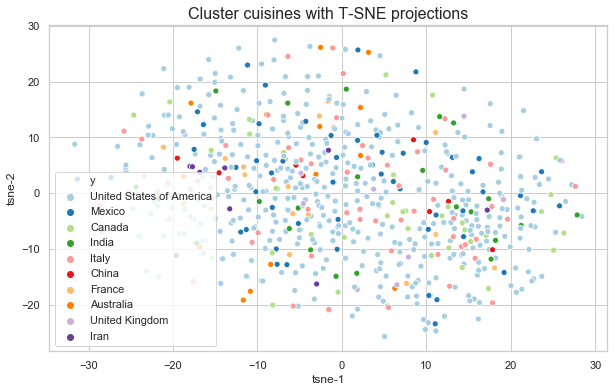

In [846]:
# Plotting the clusters on with t-sne projections
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.scatterplot("tsne-1", "tsne-2", data=df_res, palette='Paired', hue='y')
plt.title('Cluster cuisines with T-SNE projections', fontsize=16)
plt.show()